In [ ]:
!pip install small-text
!pip install datasets matplotli seaborn

In [1]:
import datasets
import torch
import numpy as np

seed = 2024
torch.manual_seed(seed)
np.random.seed(seed)

### 🗃️ Dataset Preparation
**Financial Phrasebank** is a polar sentiment dataset that contains 4840 sentences from financial news in English. Each sentence is categorized as positive, negative or neutral.

In [2]:
from datasets import load_dataset, DatasetDict
# Loading the sentiment dataset of sentences from financial news
original_dataset = load_dataset("financial_phrasebank", "sentences_allagree")

# 80% for training, 10% for test  and 10% for validation
train_test_val = original_dataset["train"].train_test_split(test_size=0.2)
# Splitting between test and validation
test_val = train_test_val["test"].train_test_split(test_size=0.5)

# Putting everything together into a single DatasetDict
dataset = DatasetDict({
    "train": train_test_val["train"],
    "test": test_val["test"],
    "validation": test_val["train"]})

dataset.num_rows
print(dataset["train"][0])

{'sentence': 'The 19,200-square metre technology center is located near University of Tampere in central Tampere .', 'label': 1}


In [3]:
model_name = "bert-base-cased"

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [4]:
num_classes = dataset["train"].features["label"].num_classes
num_classes

3

In [5]:
from small_text import TransformersDataset

target_labels = np.arange(num_classes)
train = TransformersDataset.from_arrays(dataset["train"]["sentence"], dataset["train"]["label"], \
                                        tokenizer, max_length=64, target_labels=target_labels)
test = TransformersDataset.from_arrays(dataset["test"]["sentence"], dataset["test"]["label"], \
                                       tokenizer, max_length=64, target_labels=target_labels)

/usr/local/lib/python3.10/dist-packages/small_text/utils/annotations.py:67: ExperimentalWarning: The function from_arrays is experimental and maybe subject to change soon.
  warnings.warn(f'The {subject} {func_or_class.__name__} is experimental '


### ⚙️ Model Preparation

In [6]:
from small_text import (
    PoolBasedActiveLearner,
    LightweightCoreset,
    TransformerBasedClassificationFactory,
    TransformerModelArguments,
    random_initialization_balanced
)

# Simulating initial labeling to warm-start the active learning
def initialize_active_learner(active_learner, y_train):
    indices_initial = random_initialization_balanced(y_train, n_samples=30)
    active_learner.initialize_data(indices_initial, y_train[indices_initial])
    return indices_initial

# Setting up the model and the query strategy
transformer_model = TransformerModelArguments(model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, num_classes, \
                                                    kwargs=dict({"device": "cuda", "mini_batch_size": 32, \
                                                                 "class_weight": "balanced"}))
# Other implemented strategies: https://small-text.readthedocs.io/en/v1.3.2/components/query_strategies.html
query_strategy = LightweightCoreset()

# Setting up the active learner
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train, reuse_model=True)
indices_labeled = initialize_active_learner(active_learner, train.y)

### ✅ Evaluation

In [7]:
from sklearn.metrics import accuracy_score

num_queries = 5

def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    test_acc = accuracy_score(y_pred_test, test.y)

    print("Train accuracy: {:.2f}".format(accuracy_score(y_pred, train.y)))
    print("Test accuracy: {:.2f}".format(test_acc))
    
    return test_acc


results = []
results.append(evaluate(active_learner, train[indices_labeled], test))

for i in range(num_queries):
    # Adding labeled 50 samples in each iteration
    indices_queried = active_learner.query(num_samples=30)

    # Using gold labels for illustration purposes,
    # in reality these should represent new annotations
    y = train.y[indices_queried]

    # Updating the query labels and colecting all indices for evaluation
    active_learner.update(y)
    indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
    print("---------------")
    print(f"Iteration #{i} ({len(indices_labeled)} samples)")
    results.append(evaluate(active_learner, train[indices_labeled], test))

Train accuracy: 0.67
Test accuracy: 0.22


100%|██████████████████████████████████████| 1811/1811 [00:02<00:00, 659.13it/s]


---------------
Iteration #0 (60 samples)
Train accuracy: 0.43
Test accuracy: 0.25


100%|██████████████████████████████████████| 1811/1811 [00:02<00:00, 663.00it/s]


---------------
Iteration #1 (90 samples)
Train accuracy: 0.92
Test accuracy: 0.70


100%|██████████████████████████████████████| 1811/1811 [00:02<00:00, 662.97it/s]


---------------
Iteration #2 (120 samples)
Train accuracy: 1.00
Test accuracy: 0.83


100%|██████████████████████████████████████| 1811/1811 [00:02<00:00, 659.16it/s]


---------------
Iteration #3 (150 samples)
Train accuracy: 0.98
Test accuracy: 0.85


100%|██████████████████████████████████████| 1811/1811 [00:02<00:00, 659.65it/s]


---------------
Iteration #4 (180 samples)
Train accuracy: 1.00
Test accuracy: 0.90


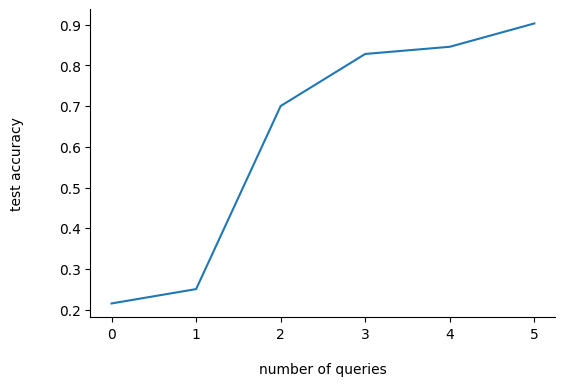

In [9]:
# Visualizing the results
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 4))
ax = plt.axes()

sns.lineplot(x=np.arange(num_queries+1), y=np.array(results))

plt.xlabel("number of queries", labelpad=15)
plt.ylabel("test accuracy", labelpad=25)

sns.despine()